In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from PIL import Image # converting images into arrays

In [2]:
%pip install -c conda-forge notebook

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'conda-forge'
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/2.0.1/libexec/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
df_can = pd.read_excel('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/Canada.xlsx',
                       sheet_name='Canada by Citizenship',
                       skiprows=range(20),
                       skipfooter=2)

print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


In [4]:
df_can.head()

,Type,Coverage,OdName,AREA,AreaName,REG,RegName,DEV,DevName,1980,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Immigrants,Foreigners,Afghanistan,935,Asia,5501,Southern Asia,902,Developing regions,16,...,2978,3436,3009,2652,2111,1746,1758,2203,2635,2004
1,Immigrants,Foreigners,Albania,908,Europe,925,Southern Europe,901,Developed regions,1,...,1450,1223,856,702,560,716,561,539,620,603
2,Immigrants,Foreigners,Algeria,903,Africa,912,Northern Africa,902,Developing regions,80,...,3616,3626,4807,3623,4005,5393,4752,4325,3774,4331
3,Immigrants,Foreigners,American Samoa,909,Oceania,957,Polynesia,902,Developing regions,0,...,0,0,1,0,0,0,0,0,0,0
4,Immigrants,Foreigners,Andorra,908,Europe,925,Southern Europe,901,Developed regions,0,...,0,0,1,1,0,0,0,0,1,1


In [5]:
# print the dimensions of the dataframe
print(df_can.shape)

(195, 43)


Clean up data. We will make some modifications to the original dataset to make it easier to create our visualizations. Refer to Introduction to Matplotlib and Line Plots and Area Plots, Histograms, and Bar Plots for a detailed description of this preprocessing.

In [6]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.sum (axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


# Visualizing Data using Matplotlib 

In [7]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

# Waffle Charts 

A waffle chart is an interesting visualization that is normally created to display progress toward goals. It is commonly an effective option when you are trying to add interesting visualization features to a visual that consists mainly of cells, such as an Excel dashboard.

Let's revisit the previous case study about Denmark, Norway, and Sweden.

In [8]:
# let's create a new dataframe for these three countries 
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]

# let's take a look at our dataframe
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


Unfortunately, unlike R, waffle charts are not built into any of the Python visualization libraries. Therefore, we will learn how to create them from scratch.

Step 1. The first step into creating a waffle chart is determing the proportion of each category with respect to the total.

In [9]:
# compute the proportion of each category with respect to the total
total_values = sum(df_dsn['Total'])
category_proportions = [(float(value) / total_values) for value in df_dsn['Total']]
print(category_proportions)
# print out proportions
for i, proportion in enumerate(category_proportions):
    print (df_dsn.index.values[i] + ': ' + str(proportion))

[0.32255663965602777, 0.1924094592359848, 0.48503390110798744]
Denmark: 0.32255663965602777
Norway: 0.1924094592359848
Sweden: 0.48503390110798744


Step 2. The second step is defining the overall size of the waffle chart.

In [10]:
width = 40 # width of chart
height = 10 # height of chart

total_num_tiles = width * height # total number of tiles

print ('Total number of tiles is ', total_num_tiles)

Total number of tiles is  400


Step 3. The third step is using the proportion of each category to determe it respective number of tiles

In [11]:
# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

# print out number of tiles per category
for i, tiles in enumerate(tiles_per_category):
    print (df_dsn.index.values[i] + ': ' + str(tiles))

Denmark: 129
Norway: 77
Sweden: 194


Based on the calculated proportions, Denmark will occupy 129 tiles of the waffle chart, Norway will occupy 77 tiles, and Sweden will occupy 194 tiles.

Step 4. The fourth step is creating a matrix that resembles the waffle chart and populating it.

In [12]:
# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        #print('sum_tiles_per_category:',sum(tiles_per_category[0:category_index]))
        if tile_index > sum(tiles_per_category[0:category_index]):
            # ...proceed to the next category
            category_index += 1       
            #print('category_index:',category_index)
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        #print('waffle_chart[row, col]',waffle_chart[row, col])
print ('Waffle chart populated!')

Waffle chart populated!



Let's take a peek at how the matrix looks like.

In [13]:
waffle_chart

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
   

Step 5. Map the waffle chart matrix into a visual.

<Figure size 432x288 with 0 Axes>

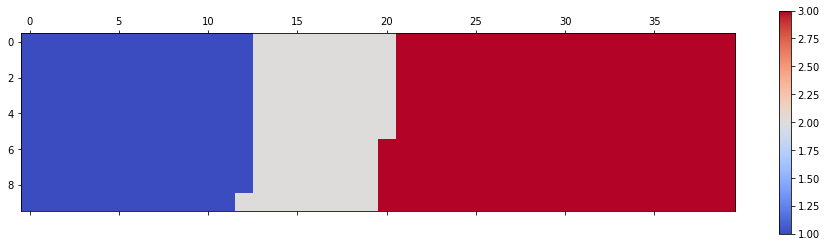

In [14]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar();

Step 6. Prettify the chart.

([], <a list of 0 Text major ticklabel objects>)

<Figure size 432x288 with 0 Axes>

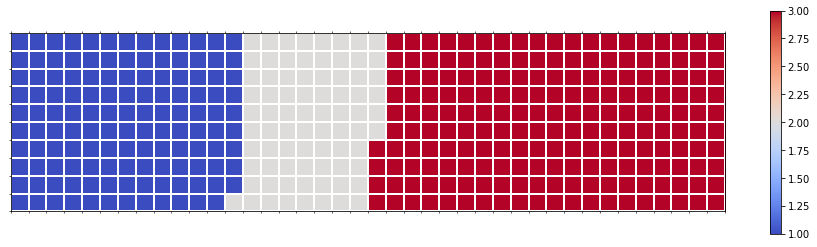

In [15]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

Step 7. Create a legend and add it to chart.

<Figure size 432x288 with 0 Axes>

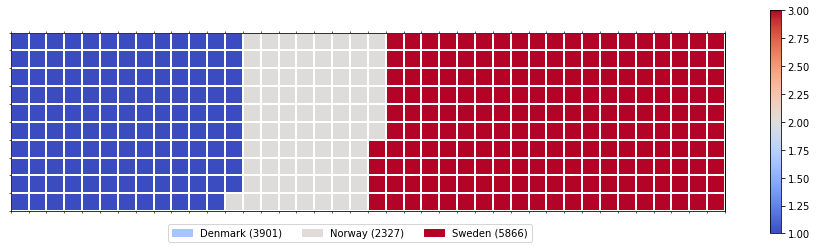

In [16]:
# instantiate a new figure object
fig = plt.figure()

# use matshow to display the waffle chart
colormap = plt.cm.coolwarm
plt.matshow(waffle_chart, cmap=colormap)
plt.colorbar()

# get the axis
ax = plt.gca()

# set minor ticks
ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
# add gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.xticks([])
plt.yticks([])

# compute cumulative sum of individual categories to match color schemes between chart and legend
values_cumsum = np.cumsum(df_dsn['Total'])
total_values = values_cumsum[len(values_cumsum) - 1]

# create legend
legend_handles = []
for i, category in enumerate(df_dsn.index.values):
    label_str = category + ' (' + str(df_dsn['Total'][i]) + ')'
    color_val = colormap(float(values_cumsum[i])/total_values)
    legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

# add legend to chart
plt.legend(handles=legend_handles,
           loc='lower center', 
           ncol=len(df_dsn.index.values),
           bbox_to_anchor=(0., -0.2, 0.95, .1)
          )

And there you go! What a good looking delicious waffle chart, don't you think?

Now it would very inefficient to repeat these seven steps every time we wish to create a waffle chart. So let's combine all seven steps into one function called create_waffle_chart. This function would take the following parameters as input:

1.**categories:** Unique categories or classes in dataframe.

2.**values:** Values corresponding to categories or classes.

3.**height:** Defined height of waffle chart.

4.**width:** Defined width of waffle chart.

5.**colormap:** Colormap class

6.**value_sign:** In order to make our function more generalizable, we will add this parameter to address signs that could be associated with a value such as %, $, and so on. value_sign has a default value of empty string.

In [17]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )

Now to create a waffle chart, all we have to do is call the function create_waffle_chart. Let's define the input parameters:

In [18]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Total'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

And now let's call our function to create a waffle chart.

Total number of tiles is 400
Denmark: 129
Norway: 77
Sweden: 194


<Figure size 432x288 with 0 Axes>

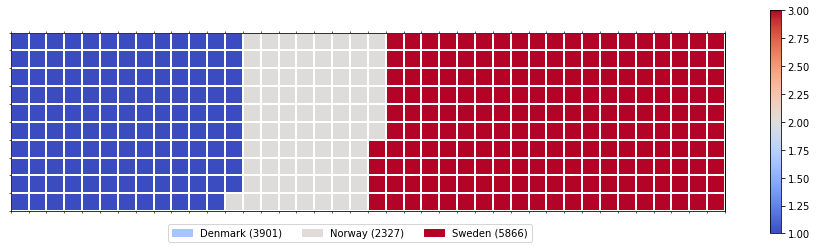

In [19]:
create_waffle_chart(categories, values, height, width, colormap)

There seems to be a new Python package for generating waffle charts called PyWaffle, but it looks like the repository is still being built. But feel free to check it out and play with it.

# Word Clouds

Word clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

Luckily, a Python package already exists in Python for generating word clouds. The package, called word_cloud was developed by Andreas Mueller. You can learn more about the package by following this link.

Let's use this package to learn how to generate a word cloud for a given text document.

First, let's install the package.

In [20]:
# install wordcloud
%pip install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')


Usage:   
  /usr/local/Cellar/jupyterlab/2.0.1/libexec/bin/python3.7 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/local/Cellar/jupyterlab/2.0.1/libexec/bin/python3.7 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/local/Cellar/jupyterlab/2.0.1/libexec/bin/python3.7 -m pip install [options] [-e] <vcs project url> ...
  /usr/local/Cellar/jupyterlab/2.0.1/libexec/bin/python3.7 -m pip install [options] [-e] <local project path> ...
  /usr/local/Cellar/jupyterlab/2.0.1/libexec/bin/python3.7 -m pip install [options] <archive url/path> ...

no such option: --yes
Note: you may need to restart the kernel to use updated packages.
Wordcloud is installed and imported!


Word clouds are commonly used to perform high-level analysis and visualization of text data. Accordinly, let's digress from the immigration dataset and work with an example that involves analyzing text data. Let's try to analyze a short novel written by Lewis Carroll titled Alice's Adventures in Wonderland. Let's go ahead and download a .txt file of the novel.

In [22]:
# open the file and read it into a variable alice_novel
alice_novel = open('./wonderland.txt', 'r').read()

In [25]:
stopwords = set(STOPWORDS)

Create a word cloud object and generate a word cloud. For simplicity, let's generate a word cloud using only the first 2000 words in the novel.

In [26]:
# instantiate a word cloud object
alice_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
alice_wc.generate(alice_novel)

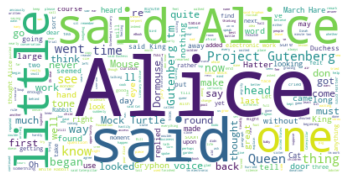

In [27]:
# display the word cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Interesting! So in the first 2000 words in the novel, the most common words are Alice, said, little, Queen, and so on. Let's resize the cloud so that we can see the less frequent words a little better.

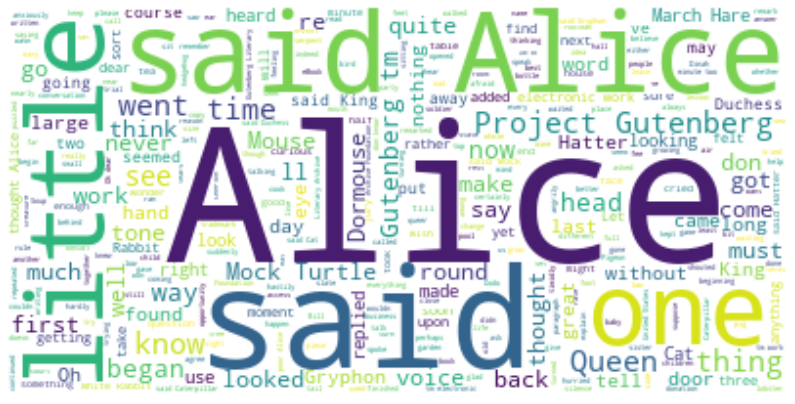

In [28]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

# display the cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Much better! However, said isn't really an informative word. So let's add it to our stopwords and re-generate the cloud.

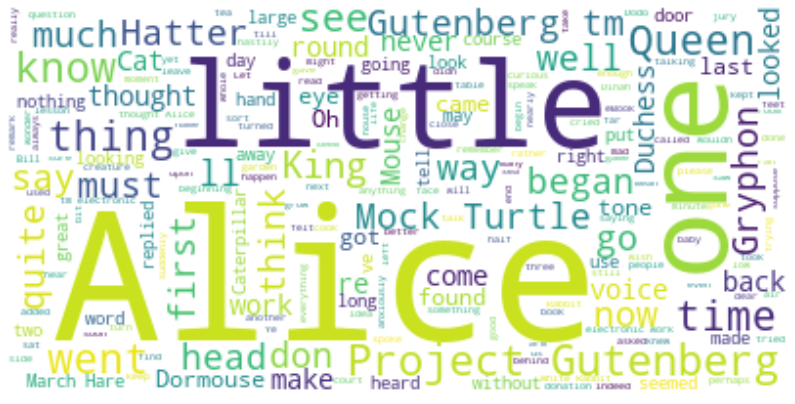

In [29]:
stopwords.add('said') # add the words said to stopwords

# re-generate the word cloud
alice_wc.generate(alice_novel)

# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Excellent! This looks really interesting! Another cool thing you can implement with the word_cloud package is superimposing the words onto a mask of any shape. Let's use a mask of Alice and her rabbit. We already created the mask for you, so let's go ahead and download it and call it alice_mask.png.

Really impressive!

Unfortunately, our immmigration data does not have any text data, but where there is a will there is a way. Let's generate sample text data from our immigration dataset, say text data of 90 words.

Let's recall how our data looks like.

In [31]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15



And what was the total immigration from 1980 to 2013?

In [32]:
total_immigration = df_can['Total'].sum()
total_immigration

6409153


Using countries with single-word names, let's duplicate each country's name based on how much they contribute to the total immigration.

In [33]:
max_words = 90
word_string = ''
for country in df_can.index.values:
    # check if country's name is a single-word name
    if len(country.split(' ')) == 1:
        repeat_num_times = int(df_can.loc[country, 'Total']/float(total_immigration)*max_words)
        word_string = word_string + ((country + ' ') * repeat_num_times)
                                     
# display the generated text
word_string

'China China China China China China China China China Colombia Egypt France Guyana Haiti India India India India India India India India India Jamaica Lebanon Morocco Pakistan Pakistan Pakistan Philippines Philippines Philippines Philippines Philippines Philippines Philippines Poland Portugal Romania '

We are not dealing with any stopwords here, so there is no need to pass them when creating the word cloud.

In [34]:
# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

Word cloud created!


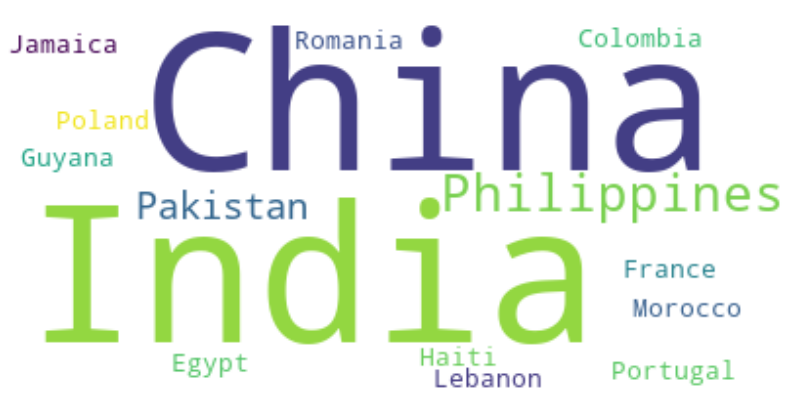

In [35]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

According to the above word cloud, it looks like the majority of the people who immigrated came from one of 15 countries that are displayed by the word cloud. One cool visual that you could build, is perhaps using the map of Canada and a mask and superimposing the word cloud on top of the map of Canada. That would be an interesting visual to build!